In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import trange

import model
from data import seq_data, grid_data
from data_analysis.visualization import hidden_repr
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

device = torch.device("cpu")

GPU not available, CPU used


In [2]:
## Generate data
symbols = [0, 1]
encoding = OneHot(symbols)
xor_problem = lambda seq: np.sum(seq) % 2
par_3_problem = lambda seq: int(np.sum(seq) % 3 == 2)
problem = xor_problem

train_datasets = [
    seq_data(device, problem, encoding, seq_len=1),
    seq_data(device, problem, encoding, seq_len=2),
    seq_data(device, problem, encoding, seq_len=3),
    # seq_data(device, problem, encoding, seq_len=4),
    # seq_data(device, problem, encoding, seq_len=5),
    # seq_data(device, problem, encoding, seq_len=6, n_datapoints=30),
    # seq_data(device, problem, encoding, seq_len=7, n_datapoints=30),
]

# train_datasets = [
#     seq_data(device, problem, encoding, seq_len=1, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=5, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=7, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=9, n_datapoints=3),
#     seq_data(device, problem, encoding, seq_len=11, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=12, n_datapoints=2),
# ]

val_dataset = [seq_data(device, problem, encoding, n_datapoints=10, seq_len=10)]
tracked_datasets = val_dataset + train_datasets


grid = grid_data(device, dim=2, output_dim=2, n=20, bounds=(-1, 1))


In [3]:
## Instantiate model
model = model.Model(
    encoding=encoding,
    input_size=2,
    output_size=2,
    hidden_dim=10,
    n_layers=4,
    device=device,
    init_std=0.1,
    # output_noise=0.01,
)

In [4]:
## Train

# Define hyperparameters
n_epochs = 100
lr = 0.001

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][-1], initial=initial_hidden
    ),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
    # "initial": ScalarTracker(lambda: model.init_hidden(batch_size=1)[-1].numpy()),
}


In [5]:
# Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=1000
)


Training: 100%|██████████| 100/100 [00:03<00:00, 32.23steps/s, train_loss=0.22594, val_loss=0.20088]


In [7]:
from data_analysis.automata import group_activations

y = group_activations(test_data, 0.1)
for group in y:
    print(group[0])


['0']
['00']
['000']
['0000000100', '0101101000']
['001']
['0011010110', '010', '0101101100', '10', '1001100110', '101', '110', '1101100010', '1101110011', '111', '1110000101']
['01']
['011', '11']
['1']
['100']
['1010010000']
['1011000001']
['initial']


In [15]:
from data_analysis.automata import to_automaton_history

z = to_automaton_history(data_hid, data_output, merge_distance=0.1)
for state in z[0].states:
    print(state.name)
    x = state.name.split(", ")


0, 00, 000, 001, 01, 010, 011, 1, 10, 100, 101, 11, 110, 111
initial


In [17]:
z[0].compute("1")

KeyError: (<data_analysis.automata.State object at 0x7fee7feb3010>, '1')

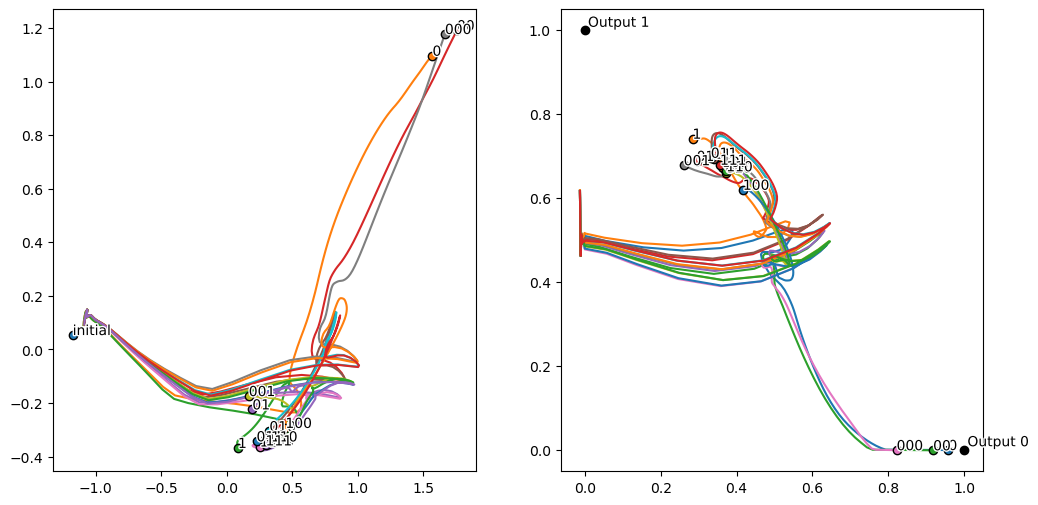

interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(width='42%'), max=99), Output()),…

In [9]:
## Show evolution of hidden states
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch >= 0"
query += "and (Dataset != 0)"
# query += "and (Dataset < 3)"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

hidden_repr(
    data_hid,
    data_output,
    transform=("PCA", "none"),
    n_labels=0,
    fig_size=6,
    encoding=encoding,
    plot_labels=True,
    # gif_path="hidden_repr",
)
# TODO Plot map A(h)
# TODO Plot pairwise distances


In [ ]:
## Plot training and validation loss during training
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.show()

In [ ]:
## Plot error per sequence length
N = 100
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=100, seq_len=n))
val_err = compiler.validation(val_data).to_numpy()[:, 0]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(np.arange(1, N + 1), val_err)
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_yticks(np.arange(0, 1, 0.1))
plt.show()

In [ ]:
def predict(model, sequence):
    input = torch.from_numpy(np.array([encoding(sequence)], dtype=np.float32)).to(
        device
    )
    out, hidden = model(input)
    prediction = out.cpu().detach().numpy()
    return prediction


x = [0, 0, 0, 1, 0, 0, 0]
print(f"Prediction: {predict(model, x)}, True output: {problem(x)}")